<a href="https://colab.research.google.com/github/avenash97/DCNN/blob/master/Social_Distancing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Distancing Detection Using Tensorflow models API



# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [0]:
%matplotlib notebook
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)


Make sure you have `pycocotools` installed

In [0]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [0]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2591, done.
remote: Counting objects: 100% (2591/2591), done.
remote: Compressing objects: 100% (2256/2256), done.
remote: Total 2591 (delta 505), reused 1445 (delta 298), pack-reused 0
Receiving objects: 100% (2591/2591), 124.11 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Checking out files: 100% (2500/2500), done.


Compile protobufs and install the object_detection package

In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [0]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017522 sha256=1e41e6949b51ec5df6c1103e4bd003fb8a2f49f28eca431e1f514e951a23f3b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-d27vn4aq/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


### Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import cv2

Import the object detection module.

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Loader

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
categories = [
              {
                  'id':1,
                  'name':'Safe',
                  'display_name':'Person - Safe',
              },
              {
                  'id':2,
                  'name':'Danger',
                  'display_name':'Person - Danger',
              },
              {
                  'id':0,
                  'name':'background',
                  'display_name':'',
              },
              
]
category_index = label_map_util.create_category_index(categories)

For the sake of simplicity we will test on 2 images:

In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# % cd "/content/drive/My Drive/"
# ! wget "https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi"
# % cd "/content"

# Detection

Load an object detection model:

In [0]:
model_name = 'mask_rcnn_resnet50_atrous_coco_2018_01_28'
detection_model = load_model(model_name)

449511424/449505463 [==============================] - 9s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [0]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [0]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_masks': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [0]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

Add a wrapper function to call the model, and cleanup the outputs:

In [0]:
import matplotlib.pyplot as plt
def find_dangerous(detection,classes,threshold,image_size,image):
  YMAX = 500
  XMAX = 1000
  src = np.float32([[283,24],[736,77],[615,398],[-204,184]])
  dst = np.float32([[0,0],[XMAX,0],[XMAX,YMAX],[0,YMAX]])
  M = cv2.getPerspectiveTransform(src, dst)
  total_elements = len(classes)
  ymin = detection[:,0]
  xmin = detection[:,1]
  ymax = detection[:,2]
  xmax = detection[:,3]
  warped_img = cv2.warpPerspective(image, M, (XMAX, YMAX))
  # display(Image.fromarray(warped_img))
  warped_img = np.zeros_like(warped_img)
  # plt.imshow(warped_img)
  coordinates = np.zeros((total_elements,2))
  coordinates[:,0] = (xmin+((xmax-xmin)/2)) * image_size[1]
  coordinates[:,1] = ymax * image_size[0] 
  for i in range(total_elements):
    # print(coordinates[i,:])
    coordinates[i,:] = cv2.perspectiveTransform(np.float32([[coordinates[i,:]]]), M).reshape(-1)
    # print(coordinates[i,:])
    # if coordinates[i,:][0]<0 or coordinates[i,:][0]>=XMAX or coordinates[i,:][1]<0 or coordinates[i,:][1]>=YMAX:
    #   classes[i] = 0
    
    # plt.scatter(coordinates[i,:][0],coordinates[i,:][1],s=200)
  for i in range(total_elements):
    root = coordinates[i,:]
    dist = np.sqrt(np.square(coordinates - root).sum(axis=1))
    dist[i] = threshold
    mask = (dist<threshold) & (dist>0)
    classes[mask] = 2
    if np.count_nonzero(mask):
      classes[i] = 2
  violations = 0
  for i in range(total_elements):
    if coordinates[i,:][0]<0 or coordinates[i,:][0]>=XMAX or coordinates[i,:][1]<0 or coordinates[i,:][1]>=YMAX:
      classes[i] = 1
      continue
    elif classes[i]==2 :
      warped_img=cv2.circle(warped_img, (int(coordinates[i,:][0]),int(coordinates[i,:][1])), 3, (255, 0, 0) , 3)
      violations+=1
    else:
      warped_img=cv2.circle(warped_img, (int(coordinates[i,:][0]),int(coordinates[i,:][1])), 3, (0, 255, 0) , 3)
  warped_img=cv2.putText(warped_img,f"Violations:{violations}",(0,55),cv2.FONT_HERSHEY_SIMPLEX,3,(255,0,0),2,cv2.LINE_AA)
  # display(Image.fromarray(warped_img))
  # plt.show()
  # display(Image.fromarray(warped_img))  
  return classes,image,warped_img


In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # w,h = image.shape
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  mask = output_dict['detection_classes']==1
  # output_dict['detection_classes'] = output_dict['detection_classes'][mask]
  output_dict = {key:value[mask]
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = mask.sum()
  # print(output_dict['detection_boxes'])
  THRESHOLD = 25
  # print("DETECTIONS:",output_dict['detection_boxes'])
  output_dict['detection_classes'],image,warped_img = find_dangerous(output_dict['detection_boxes'],output_dict['detection_classes'],THRESHOLD,image.shape,image)

   
  # Handle models with masks:
  # if 'detection_masks' in output_dict:
  #   # Reframe the the bbox mask to the image size.
  #   detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
  #             output_dict['detection_masks'], output_dict['detection_boxes'],
  #              image.shape[0], image.shape[1])      
  #   detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
  #                                      tf.uint8)
  #   output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict,image,warped_img

Run it on each test image and show the results:

In [0]:
from tqdm.notebook import tqdm
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  cap = cv2.VideoCapture('/content/drive/My Drive/video-passengers-milling-about-with-carts.mp4')
  total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  temp = 0
  once = True
  for _ in tqdm(range(total)):
    
    ret, image_np = cap.read()
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    # if temp%30 and temp :
    #   temp+= 1
    #   continue
    # image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict,image_np,warped_img = run_inference_for_single_image(model, image_np)

    # print(output_dict)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)
    temp+= 1
    warped_img = cv2.resize(warped_img,(500,image_np.shape[0]))
    image_np = cv2.hconcat([image_np, warped_img])
    w,h,_ = image_np.shape
    if once:
      display(Image.fromarray(image_np))
      out = cv2.VideoWriter('/content/outpy_test.avi',cv2.VideoWriter_fourcc(*'XVID'), 20, (h,w))
      once = False
    out.write(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))
  cap.release()
  out.release()
    # display(Image.fromarray(image_np))


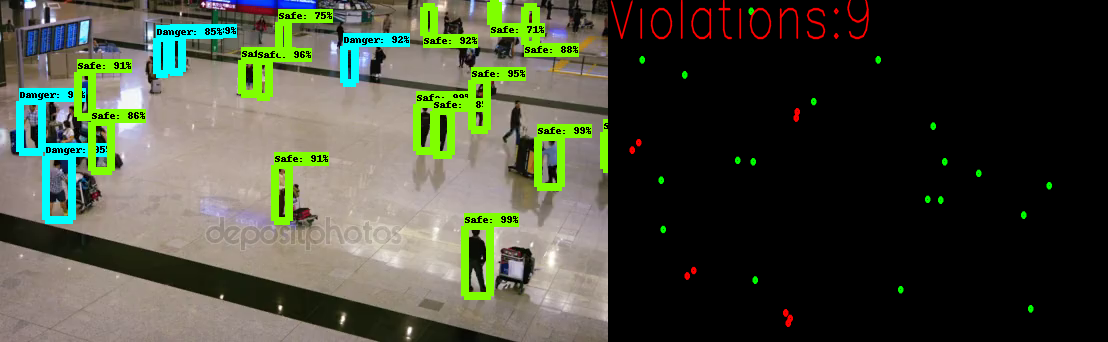

In [0]:
# for image_path in TEST_IMAGE_PATHS:
show_inference(detection_model, "dqwd")